# Classification Experiments 
By: Shateesh Bhugwansing


### Experiment 1 - Logistic Regression

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify target vs. flanker stimuli 

__Procedure__:
1. perform PCA on data to reduce the number of channels 129 to 9
2. reassign event_id's for each epoch. target = 140, flanker = 160
3. Run logistic regression classifier on the original data
4. Run the same classifier in step 3, on the PCA data and compare results. 
    

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (50.0, 30.0)
matplotlib.rcParams.update({'font.size': 15})

In [3]:
path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(path, preload=True)


Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [14]:
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA

In [15]:
pca = UnsupervisedSpatialFilter(PCA(9), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
pca_data = pca.fit_transform(epoch_data)

In [23]:
import pickle

pickle.dump(pca_data, open('pca_data_20131216_1441.pkl', 'wb'))
pickle.dump(epoch_data, open('epoch_data_20131216_1441.pkl', 'wb'))

In [17]:
filtered_epoch = epoch[(epoch.events[:,-1] >= 135) & (epoch.events[:,-1] <= 165)]

In [24]:
pickle.dump(filtered_epoch, open('filtered_epoch_20131216_1441.pkl', 'wb'))

In [20]:
filtered_epoch_data = filtered_epoch.get_data()
filtered_epoch_data.shape

(1280, 129, 180)

In [21]:
filtered_pca_data = pca.fit_transform(filtered_epoch_data)
filtered_pca_data.shape

(1280, 9, 180)

In [22]:
pickle.dump(filtered_epoch_data, open('filtered_epoch_data_20131216_1441.pkl', 'wb'))
pickle.dump(filtered_pca_data, open('filtered_pca_data_20131216_1441.pkl', 'wb'))

In [25]:
# change the event id to '140' for target, and '160' for flanker. 

for x in filtered_epoch.events:
    if x[-1] <= 145:
        x[-1] = 140
    else:
        x[-1] = 160

In [ ]:
filtered_epoch.events

### Logistic Regression on epoched data (129 Channels) 

In [71]:
# use logistic regression, L1 penalty 

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report


from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer


clf = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))

# logReg = LogisticRegression()

#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = filtered_epoch.events[:,-1]
preds = np.empty(len(filtered_epoch))
for train, test in cv.split(filtered_epoch, labels):
    clf.fit(filtered_epoch.get_data()[train], labels[train])
    preds[test] = clf.predict(filtered_epoch.get_data()[test])
    
target_names = [ '140', '160']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        140       1.00      1.00      1.00       640
        160       1.00      1.00      1.00       640

avg / total       1.00      1.00      1.00      1280



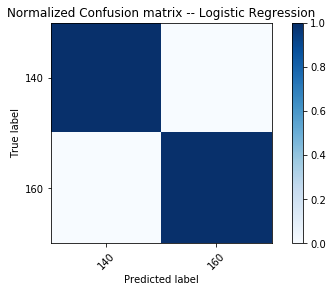

In [78]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Experiment 2 - SVM

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify target vs. flanker stimuli 

__Procedure__:
1. perform PCA on data to reduce the number of channels 129 to 9
2. reassign event_id's for each epoch. target = 140, flanker = 160
3. Run SVM classifier on the original data
4. Run the same classifier in step 3, on the PCA data and compare results. 
    

In [76]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

cv2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
svc = SVC(C=1, kernel='linear')


clf2 = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    svc)


labels2 = filtered_epoch.events[:,-1]
preds2 = np.empty(len(filtered_epoch))
for train2, test2 in cv.split(filtered_epoch, labels2):
    clf.fit(filtered_epoch.get_data()[train2], labels[train2])
    preds2[test2] = clf.predict(filtered_epoch.get_data()[test2])
    
target_names2 = [ '140', '160']
report2 = classification_report(labels2, preds2, target_names=target_names2)
print(report2)

             precision    recall  f1-score   support

        140       1.00      1.00      1.00       640
        160       1.00      1.00      1.00       640

avg / total       1.00      1.00      1.00      1280



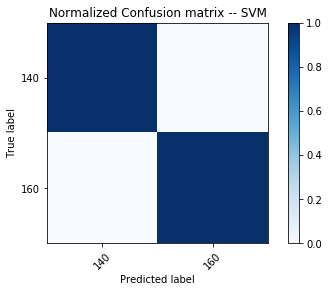

In [79]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(labels2, preds2)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- SVM')
plt.colorbar()
tick_marks = np.arange(len(target_names2))
plt.xticks(tick_marks, target_names2, rotation=45)
plt.yticks(tick_marks, target_names2)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [82]:
filtered_epoch.event_id

{'t_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165}

In [ ]:
# try scatter plot of events data, see if the data already has a clear divide 